# Exploring Batch 3 Replicate Correlation

**Gregory Way, 2019**

In [3]:
import os
import numpy as np
import pandas as pd
import plotnine as gg

from pycytominer.cyto_utils.features import drop_outlier_features
from pycytominer import audit

In [4]:
def plot_replicate_corr(x_df):
    plot_obj = gg.ggplot(x_df, gg.aes(x="correlation", fill="replicate")) + \
        gg.geom_density(alpha = 0.3) + \
        gg.scale_fill_manual(name="Replicate",
                             labels={"True": "True",
                                     "False": "False"},
                             values=["#B99638", "#2DB898"]) + \
        gg.xlab("Pearson Correlation") + \
        gg.ylab("Density") + \
        gg.theme_light()
    return plot_obj

def plot_individual_replicate_corr(x_df):
    # Process input data to ensure all sample correlations are captured in
    # one column, but that replicate correlation is not captured
    left_df = (
        x_df
        .loc[:, ["Metadata_clone_number_b", "correlation", "replicate"]]
        .reset_index(drop=True)
        .rename({"Metadata_clone_number_b": "Metadata_clone_number"}, axis='columns')
    )
    right_df = (
        x_df
        .loc[:, ["Metadata_clone_number", "correlation", "replicate"]]
        .query("replicate == False")
        .reset_index(drop=True)
    )

    x_df = pd.concat([left_df, right_df], axis='rows', ignore_index=True)

    # Now plot
    plot_obj = gg.ggplot(x_df, gg.aes(y="correlation", x="replicate", fill="replicate")) + \
        gg.geom_jitter(shape = ".", size=0.5, alpha=0.3) + \
        gg.geom_boxplot(alpha=0.3, outlier_alpha=0) + \
        gg.scale_fill_manual(name="Replicate",
                             labels={"True": "True",
                                     "False": "False"},
                             values=["#B99638", "#2DB898"]) + \
        gg.xlab("Replicates") + \
        gg.ylab("Pearson Correlation") + \
        gg.theme_light() + \
        gg.theme(subplots_adjust={'wspace': 0.2},
                 axis_text=gg.element_text(size=7),
                 axis_title=gg.element_text(size=9),
                 strip_text=gg.element_text(size=6, color="black"),
                 strip_background=gg.element_rect(colour="black",
                                                  fill="#fdfff4")) + \
        gg.facet_wrap("~Metadata_clone_number")
    return plot_obj

In [5]:
batch = "2019_11_19_Batch5"
profile_dir = os.path.join("..", "..", "1.process-profiles", "profiles")
batch_dir = os.path.join(profile_dir, batch)

backend_folders = os.listdir(batch_dir)
plate_files = [
    os.path.join(batch_dir, x, "{}_normalized_variable_selected.csv".format(x))
    for x in backend_folders if ".DS_Store" not in x
]

print(plate_files)

['../1.process-profiles/profiles/2019_11_19_Batch5/217755/217755_normalized_variable_selected.csv']


## Read in Files

In [9]:
df = pd.read_csv(plate_files[0])
exclude_features = drop_outlier_features(df)
df = df.drop(exclude_features, axis="columns")

print(df.shape)
df.head(2)

(60, 156)


,Metadata_Plate,Metadata_Well,Metadata_Assay_Plate_Barcode,Metadata_Plate_Map_Name,Metadata_well_position,Metadata_clone_number,Metadata_plate_ID,Metadata_plate_filename,Metadata_treatment,Cells_AreaShape_Compactness,Cells_AreaShape_EulerNumber,Cells_AreaShape_Extent,Cells_AreaShape_Orientation,Cells_AreaShape_Zernike_0_0,Cells_AreaShape_Zernike_1_1,Cells_AreaShape_Zernike_2_2,Cells_AreaShape_Zernike_3_3,Cells_AreaShape_Zernike_4_0,Cells_AreaShape_Zernike_4_2,Cells_AreaShape_Zernike_4_4,Cells_AreaShape_Zernike_5_1,Cells_AreaShape_Zernike_5_3,Cells_AreaShape_Zernike_5_5,Cells_AreaShape_Zernike_6_0,Cells_AreaShape_Zernike_6_2,Cells_AreaShape_Zernike_6_4,Cells_AreaShape_Zernike_6_6,Cells_AreaShape_Zernike_7_1,Cells_AreaShape_Zernike_7_7,Cells_AreaShape_Zernike_8_0,Cells_AreaShape_Zernike_8_2,Cells_AreaShape_Zernike_8_4,Cells_AreaShape_Zernike_8_6,Cells_AreaShape_Zernike_8_8,Cells_AreaShape_Zernike_9_1,Cells_AreaShape_Zernike_9_3,Cells_Correlation_K_DNA_Mito,Cells_Correlation_K_ER_DNA,Cells_Correlation_Overlap_DNA_AGP,Cells_Correlation_Overlap_DNA_Mito,Cells_Correlation_Overlap_DNA_RNA,Cells_Correlation_Overlap_Mito_ER,Cells_Correlation_Overlap_Mito_RNA,Cells_Correlation_Overlap_RNA_AGP,Cells_Granularity_2_AGP,Cells_Intensity_IntegratedIntensityEdge_AGP,Cells_Intensity_IntegratedIntensity_AGP,Cells_Intensity_IntegratedIntensity_DNA,Cells_Intensity_IntegratedIntensity_ER,Cells_Intensity_IntegratedIntensity_Mito,Cells_Intensity_MassDisplacement_DNA,Cells_RadialDistribution_MeanFrac_DNA_3of4,Cells_RadialDistribution_RadialCV_DNA_1of4,Cells_RadialDistribution_RadialCV_Mito_1of4,Cells_RadialDistribution_RadialCV_RNA_1of4,Cells_Texture_AngularSecondMoment_DNA_10_03,Cells_Texture_AngularSecondMoment_DNA_20_03,Cells_Texture_Correlation_AGP_20_03,Cells_Texture_Correlation_DNA_20_03,Cells_Texture_Correlation_DNA_5_00,Cells_Texture_InfoMeas2_DNA_5_00,Cells_Texture_SumAverage_DNA_20_03,Cytoplasm_AreaShape_Center_Y,Cytoplasm_AreaShape_Eccentricity,Cytoplasm_AreaShape_EulerNumber,Cytoplasm_AreaShape_Orientation,Cytoplasm_AreaShape_Zernike_1_1,Cytoplasm_AreaShape_Zernike_2_0,Cytoplasm_AreaShape_Zernike_3_1,Cytoplasm_AreaShape_Zernike_3_3,Cytoplasm_AreaShape_Zernike_5_3,Cytoplasm_AreaShape_Zernike_5_5,Cytoplasm_AreaShape_Zernike_6_4,Cytoplasm_AreaShape_Zernike_7_7,Cytoplasm_AreaShape_Zernike_8_4,Cytoplasm_AreaShape_Zernike_8_6,Cytoplasm_AreaShape_Zernike_8_8,Cytoplasm_AreaShape_Zernike_9_5,Cytoplasm_Correlation_K_AGP_RNA,Cytoplasm_Correlation_K_DNA_AGP,Cytoplasm_Correlation_K_DNA_ER,Cytoplasm_Correlation_K_DNA_Mito,Cytoplasm_Correlation_Overlap_DNA_ER,Cytoplasm_Correlation_Overlap_ER_RNA,Cytoplasm_Correlation_Overlap_Mito_AGP,Cytoplasm_Correlation_Overlap_Mito_ER,Cytoplasm_Granularity_2_AGP,Cytoplasm_Granularity_2_ER,Cytoplasm_Granularity_2_Mito,Cytoplasm_Granularity_2_RNA,Cytoplasm_Granularity_3_AGP,Cytoplasm_Granularity_3_Mito,Cytoplasm_Granularity_3_RNA,Cytoplasm_Intensity_IntegratedIntensity_ER,Cytoplasm_Intensity_IntegratedIntensity_Mito,Cytoplasm_Intensity_IntegratedIntensity_RNA,Cytoplasm_Intensity_LowerQuartileIntensity_AGP,Cytoplasm_Location_CenterMassIntensity_X_AGP,Cytoplasm_RadialDistribution_FracAtD_DNA_1of4,Cytoplasm_RadialDistribution_FracAtD_Mito_1of4,Cytoplasm_RadialDistribution_MeanFrac_DNA_1of4,Cytoplasm_RadialDistribution_MeanFrac_Mito_1of4,Cytoplasm_Texture_AngularSecondMoment_DNA_10_01,Cytoplasm_Texture_AngularSecondMoment_ER_5_00,Cytoplasm_Texture_AngularSecondMoment_Mito_5_02,Cytoplasm_Texture_Correlation_AGP_20_02,Cytoplasm_Texture_Correlation_DNA_10_02,Cytoplasm_Texture_Correlation_Mito_5_02,Cytoplasm_Texture_DifferenceVariance_DNA_20_03,Cytoplasm_Texture_Entropy_ER_20_00,Cytoplasm_Texture_InfoMeas2_DNA_5_00,Cytoplasm_Texture_InfoMeas2_ER_20_01,Cytoplasm_Texture_InfoMeas2_ER_5_02,Cytoplasm_Texture_InfoMeas2_Mito_5_02,Nuclei_AreaShape_Eccentricity,Nuclei_AreaShape_MajorAxisLength,Nuclei_AreaShape_Orientation,Nuclei_AreaShape_Zernike_2_2,Nuclei_AreaShape_Zernike_4_2,Nuclei_AreaShape_Zernike_6_2,Nuclei_AreaShape_Zernike_8_0

## How Many Replicates?

In [10]:
df.groupby(replicate_columns).size().reset_index().rename(columns={0:'replicate_count'})

Metadata_treatment,DMSO,bortezomib
Metadata_clone_number,,
BZ001,3,3
BZ008,3,3
BZ017,3,3
BZ018,3,3
WT002,3,3
WT008,3,3
WT009,3,3
WT011,3,3
WT_parental,9,3


## Get Pairwise Correlations

In [35]:
mut_cor_df = audit(df, audit_groups=replicate_columns, audit_resolution="full")

In [37]:
for col in replicate_columns:
    a = mut_cor_df.columns.str.contains(col)

In [43]:
mut_cor_df.loc[:, mut_cor_df.columns[a]].head().difference()

AttributeError: 'DataFrame' object has no attribute 'difference'

In [36]:
replicate_columns

['Metadata_clone_number', 'Metadata_treatment']

In [12]:
mut_cor_df = (
    mut_cor_df
    .assign(replicate = 
            (
                (
                    mut_cor_df.Metadata_clone_number_pair_a ==
                    mut_cor_df.Metadata_clone_number_pair_b
                ) &
                (
                    mut_cor_df.Metadata_treatment_pair_a ==
                    mut_cor_df.Metadata_treatment_pair_b
                )
            )
           )
)

print(mut_cor_df.shape)
mut_cor_df.head(2)

(1770, 9)


,column_match_pair_a,Metadata_clone_number_pair_a,Metadata_treatment_pair_a,row_match,pairwise_correlation,column_match_pair_b,Metadata_clone_number_pair_b,Metadata_treatment_pair_b,replicate
1,1,WT002,DMSO,0,0.423383,0,BZ017,DMSO,False
2,2,WT008,DMSO,0,-0.240158,0,BZ017,DMSO,False


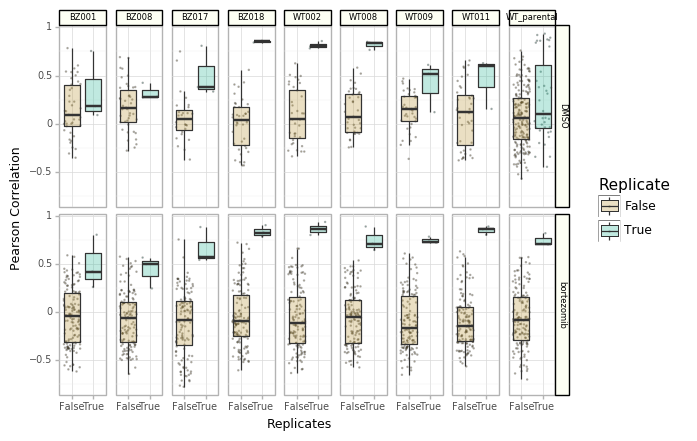

<ggplot: (-9223372036581925372)>

In [19]:
gg.ggplot(mut_cor_df, gg.aes(y="pairwise_correlation", x="replicate", fill="replicate")) + \
        gg.geom_jitter(shape = ".", size=0.5, alpha=0.3) + \
        gg.geom_boxplot(alpha=0.3, outlier_alpha=0) + \
        gg.scale_fill_manual(name="Replicate",
                             labels={"True": "True",
                                     "False": "False"},
                             values=["#B99638", "#2DB898"]) + \
        gg.xlab("Replicates") + \
        gg.ylab("Pearson Correlation") + \
        gg.theme_light() + \
        gg.theme(subplots_adjust={'wspace': 0.2},
                 axis_text=gg.element_text(size=7),
                 axis_title=gg.element_text(size=9),
                 strip_text=gg.element_text(size=6, color="black"),
                 strip_background=gg.element_rect(colour="black",
                                                  fill="#fdfff4")) + \
        gg.facet_grid("Metadata_treatment_pair_a~Metadata_clone_number_pair_a")

## Output Median Replicate Correlation

We use this later for platemap visualization.

In [10]:
wt_median_cor_df = (
    wt_cor_df
    .groupby(["Metadata_clone_number", "replicate"])
    .median()
    .reset_index()
)

mut_median_cor_df = (
    mut_cor_df
    .groupby(["Metadata_clone_number", "replicate"])
    .median()
    .reset_index()
)

# Save Files
file = os.path.join("results", "wed_median_replicate_correlation.tsv")
wt_median_cor_df.to_csv(file, sep='\t', index=False)

file = os.path.join("results", "th_median_replicate_correlation.tsv")
mut_median_cor_df.to_csv(file, sep='\t', index=False)